In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses,optimizers
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from numpy.testing import assert_allclose
import pickle

In [ ]:
def AlexNet(input_shape, num_classes):
    model=tf.keras.models.Sequential()
    model.add(layers.experimental.preprocessing.Resizing(227, 227, interpolation="bilinear", input_shape=input_shape))

    model.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),activation='relu',input_shape=(227, 227,3),padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(layers.Conv2D(filters=256, kernel_size=(5,5), padding="same",activation="relu",strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(layers.Conv2D(kernel_size=(3,3),filters=384,activation='relu',padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=384,kernel_size=(3,3),padding='same',activation='relu',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3),padding='same',activation='relu',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes,activation='softmax'))
    return model

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Dense, Resizing

def resnet50(input_shape, num_classes):
    # Input tensor
    inputs = Input(shape=input_shape)

    # Stage 1

    x=Resizing(224, 224, interpolation="bilinear", input_shape=input_shape)(inputs)
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Stage 2
    x = convolutional_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    # x = identity_block(x, [64, 64, 256])

    # Stage 3
    x = convolutional_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    # x = identity_block(x, [128, 128, 512])
    # x = identity_block(x, [128, 128, 512])

    # Stage 4
    x = convolutional_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    # x = identity_block(x, [256, 256, 1024])
    # x = identity_block(x, [256, 256, 1024])
    # x = identity_block(x, [256, 256, 1024])
    # x = identity_block(x, [256, 256, 1024])

    # Stage 5
    x = convolutional_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])
    # x = identity_block(x, [512, 512, 2048])

    # Output layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=x)

    return model


def identity_block(input_tensor, filters):
    filters1, filters2, filters3 = filters

    x = Conv2D(filters1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)

    return x


def convolutional_block(input_tensor, filters, strides=(2, 2)):
    filters1, filters2, filters3 = filters

    x = Conv2D(filters1, kernel_size=(1, 1), strides=strides, padding='valid')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters3, kernel_size=(1, 1), strides=strides, padding='valid')(input_tensor)
    shortcut = BatchNormalization()(shortcut)


    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x


In [3]:
num_classes = 100
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train_full=tf.keras.utils.to_categorical(y_train_full,num_classes=num_classes)
y_test=tf.keras.utils.to_categorical(y_test,num_classes=num_classes)

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)


169001437/169001437 [==============================] - 6s 0us/step


In [4]:
input_shape=x_train.shape[1:]
input_shape

(32, 32, 3)

In [5]:

def train_model():
    # Create and compile your model
    model = resnet50(input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Define the checkpoint path
    checkpoint_path = "/content/checkpoint/model_{epoch}.h5"

    # Create a checkpoint callback
    checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=False, save_freq='epoch')


    # Train the model

    history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_val, y_val), callbacks=[checkpoint_callback])

    # Save the model
    model.save(f"model_resnet.h5")


    # Save the history
    with open(f"history_resnet.pkl", 'wb') as file:
        pickle.dump(history.history, file)

In [6]:
train_model()

Epoch 1/50
313/313 [==============================] - 296s 806ms/step - loss: 4.0243 - accuracy: 0.0999 - val_loss: 4.4681 - val_accuracy: 0.0517
Epoch 2/50
313/313 [==============================] - 265s 846ms/step - loss: 3.4021 - accuracy: 0.1854 - val_loss: 4.7370 - val_accuracy: 0.1210
Epoch 3/50
313/313 [==============================] - 263s 841ms/step - loss: 2.9526 - accuracy: 0.2644 - val_loss: 3.6987 - val_accuracy: 0.1707
Epoch 4/50
313/313 [==============================] - 269s 859ms/step - loss: 2.5155 - accuracy: 0.3459 - val_loss: 3.3470 - val_accuracy: 0.2371
Epoch 5/50
313/313 [==============================] - 268s 858ms/step - loss: 2.1788 - accuracy: 0.4181 - val_loss: 3.0213 - val_accuracy: 0.3677
Epoch 6/50
313/313 [==============================] - 270s 862ms/step - loss: 1.8938 - accuracy: 0.4805 - val_loss: 2.4602 - val_accuracy: 0.3745
Epoch 7/50
313/313 [==============================] - 270s 862ms/step - loss: 1.6430 - accuracy: 0.5419 - val_loss: 3.2020 -

In [ ]:
import time
for i in range(4,10):
  time.sleep(200)
  print(i)

4
5
6


In [8]:
def plot_history(history):
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()



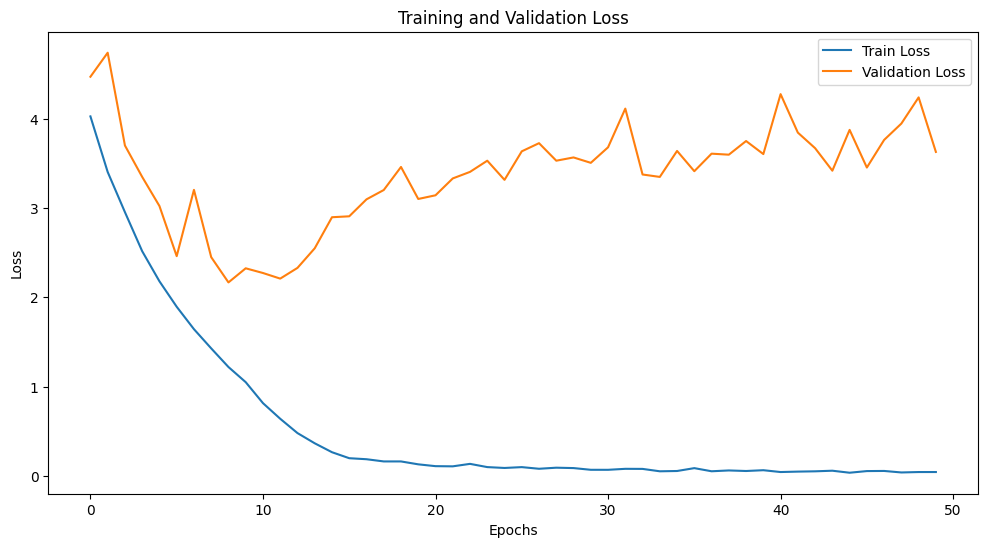

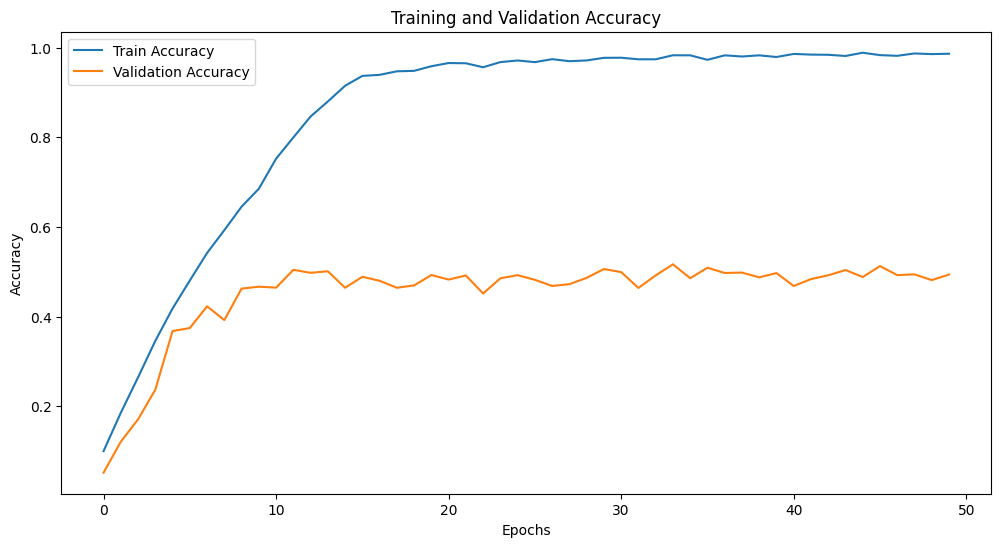

In [9]:
with open("/content/history_resnet.pkl", 'rb') as f:
    history = pickle.load(f)

# Plot combined history
plot_history(history)